# Лабораторная работа 1

### Вариант 12

### Задачи

- реализовать нейронную сеть на основе numpy;
- обучить созданную нейронную сеть.

#### Импорт данных

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import clear_output
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

%matplotlib inline

from util import load_mnist
from util import plot_embedding

In [27]:
class Layer:

    def __init__(self):
        pass
    
    def forward(self, input):
        return input

    def backward(self, input, grad_output):
        input_dim = input.shape[1]
        
        d_layer_d_input = np.eye(input_dim)
        
        return np.dot(grad_output, d_layer_d_input)

#### ReLU слой

In [28]:
class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        relu_output = np.maximum(0, input)
        return relu_output
    
    def backward(self, input, grad_output):
        relu_grad_mask = input > 0
        return grad_output * relu_grad_mask

#### Полносвязный слой

In [29]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self, input):
        output = np.dot(input, self.weights) + self.biases
        return output

    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

#### Функция потерь

In [31]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

#### Итоговая нейросеть

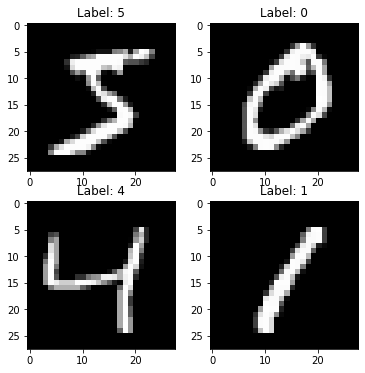

In [32]:
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [33]:
network = []
hidden_layers_size = 40
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))

Реализуем прямой проход по целой сети, последовательно вызывая .forward() для каждого слоя.

In [47]:
def forward(network, X):
    
    activations = []
    input = X
    
    for layer in network:
        input = layer.forward(input)
        activations.append(input)
    
    assert len(activations) == len(network)
    
    return activations

In [48]:
def train(network, X, y):
    
    # Get the layer activations
    layer_activations = forward(network, X)
    layer_inputs = [X] + layer_activations  # layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)
        
    # Propagate gradients through network layers using .backward
    # Start from the last layer and move to earlier layers
    grad_output = loss_grad
    for layer_input, layer in zip(reversed(layer_inputs[:-1]), reversed(network)):
        grad_output = layer.backward(layer_input, grad_output)
        
    return np.mean(loss)

Все готово для запуска обучения. Если все реализовано корректно, то точность классификации на валидационном множестве должна превысить 97%.

In [49]:
from tqdm.auto import tqdm
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Начинаем обучение

In [50]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 14
Train accuracy: 0.9937
Val accuracy: 0.9706


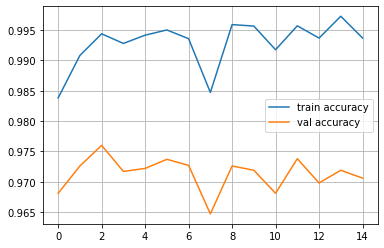

In [51]:
for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

#### Нейросеть для извлечения представлений

Вычислим представления:

In [52]:
train_activations = forward(network, X_train)
train_hidden_representations = train_activations[2]
test_activations = forward(network, X_test)
test_hidden_representations = test_activations[2]

Полученные представления можно использовать в любых целях, в комбинации с другими инструментами машинного обучения. Сравним обученные представления для изображений из MNIST c исходными 784-мерными представлениями. Построим t-SNE визуализации 1000 случайных изображений из X_train, полученные на основе исходных 784-мерных представлений и обученных представлений. Сделаем вывод о качестве представлений.

In [54]:
from sklearn.manifold import TSNE
subset_ids = np.random.permutation(X_train.shape[0])[:1000]

x_original = X_train[subset_ids]
x_learnt = train_hidden_representations[subset_ids]
x_original_tsne = TSNE(n_components=2).fit_transform(x_original)
x_learnt_tsne = TSNE(n_components=2).fit_transform(x_learnt)

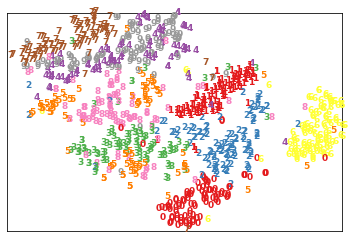

In [55]:
plot_embedding(x_original_tsne, y_train[subset_ids])

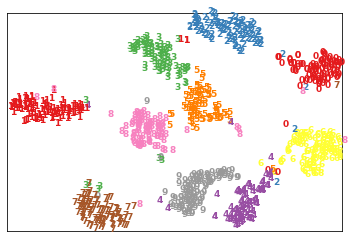

In [56]:
plot_embedding(x_learnt_tsne, y_train[subset_ids])

Наконец, исследуем универсальность полученных представлений. Используем их для решения другой задачи классификации: предсказание четности изображенной цифры.

In [57]:
new_y_train = y_train % 2
new_y_test = y_test % 2

Обучим простейшую логистическую регресиию, предсказывающую четность изображенной цифры, используя в качестве вектора признаков:
* исходные 784-мерные представления
* обученные представления

Сравним качество и сделайте вывод об универсальности обученных представлений.

In [59]:
lr = LogisticRegression(solver="lbfgs")

train_repr = train_hidden_representations
test_repr = test_hidden_representations

lr.fit(train_repr, new_y_train)

accuracy = lr.score(test_repr, new_y_test)
print(f"Accuracy of parity prediction: {accuracy}")

Accuracy of parity prediction: 0.9446


C:\Users\Mvideo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Контрольные вопросы

1. Биологический и искусственный нейрон. Основные функции активации нейронов.
    
    Биологический нейрон: Это базовая единица нервной системы животных и людей. Биологический нейрон состоит из дендритов (входные каналы), сомы (ядра), аксона (выходной канал) и синапсов (связи между нейронами). Когда электрический сигнал достигает сомы, он может привести к выходу сигнала через аксон к другим нейронам.

    Искусственный нейрон: Это математическая абстракция, моделирующая работу биологического нейрона. Он имеет входы, веса (коэффициенты), функцию активации и выход. Входные значения умножаются на соответствующие веса, а затем проходят через функцию активации, которая определяет, будет ли активирован нейрон и с какой интенсивностью будет передан сигнал.
    
    Функции:
    * Сигмоидальная: Преобразует входной сигнал в значения в диапазоне от 0 до 1, полезно для задач бинарной классификации.
    * Ступенчатая функция: Функция А = активирована, если Y > граница, иначе нет. Другой способ:  A = 1, если Y > граница, иначе А = 0.
    * Линейная функция: Линейная функция представляет собой прямую линию и пропорциональна входу (то есть взвешенной сумме на этом нейроне).
    * Гиперболический тангенс: Скорректированная сигмоидная функция.
    * ReLu: ReLu возвращает значение х, если х положительно, и 0 в противном случае. 
    
2. Преимущества нейронных сетей.

    * Самообучаемость. Отличительной чертой и достоинством ИНС является то, что алгоритм самостоятельно принимает решения о том, как выполнить заданную задачу, иногда применяя не совсем или вовсе не очевидные для людей методы. Нейронные сети также созданы с расчетом на постоянное улучшение собственных результатов.
    * Эффективная фильтрация шумов. Нейросети могут игнорировать шумы и обрабатывать лишь необходимую информацию.
    * Адаптация. Адаптация позволяет нейронным сетям быть готовыми к возможным переменам во входных данных и продолжать работать эффективно. После небольшого периода адаптации они будут готовы к работе.
    * Отказоустойчивость. Искусственные нейронные сети обладают отказоустойчивостью: даже при повреждении некоторых нейронов остальные продолжают функционировать и выдавать логичные и правильные ответы, хотя точность их работы уменьшится.
    * Скорость работы. ИНС состоит из множества микропроцессоров, которые позволяют решать задачи быстрее, нежели при применении обычных алгоритмов. Быстродействие зависит от вычислительной мощности.

3. Классификации нейронных сетей, области применения и решаемые задачи. Основные направления развития нейрокомпьютинга.
    Классификация:
    * По типу обучения:
        1. С учителем
        2. Без учителя
        3. С подкреплением
    * По архитектуре:
        1. Свёрточные нейронные сети (Convolutional neural network, CNN): Состоят из слоёв пяти типов - входного, свёртывающего, объединяющего, подключённого, выходного.
        2. Рекуррентные нейронные сети (Recurrent neural network, RNN): Используют направленную последовательность связи между узлами. В RNN результат вычислений на каждом этапе используется в качестве исходных данных для следующего.
        
     Область применения:
         1. Распознавание образов: Например, распознавание лиц, объектов на изображениях.
         2. Естественный язык: Для обработки текста, машинного перевода, синтеза речи.
         3. Прогнозирование и анализ: Прогнозирование временных рядов, анализ данных.
         4. Управление: Например, автопилоты в автомобилях, автономные роботы.
         
     Решаемые задачи:
        * Диагностирование заболеваний на основе базы медицинских изображений
        * Фильтрация соцсетей и анализ поведения пользователей для целевого маркетинга
        * Предсказание финансовых процессов путем обработки данных о ранее произошедших явлениях на рынках валют и ценных бумаг
        * Прогнозирование потребности в ресурсах, например, в водоснабжении или электрической энергии
        * Контроль качества производимой продукции
        * Определение химических соединений
        
    Основные направления развития нейрокомпьютинга:
        * Исследование нейрональных сетей: Это включает в себя изучение биологических нейронных сетей, их структуры и функций, а также разработку математических моделей, которые отражают их поведение. Это позволяет понять основные принципы обработки информации в нейронах и как они могут быть применены в вычислительных системах.
        * Развитие алгоритмов машинного обучения и глубокого обучения: Глубокое обучение является подразделом машинного обучения, в котором строятся искусственные нейронные сети с множеством слоев, способных обрабатывать большие объемы данных и извлекать сложные закономерности. Развитие новых алгоритмов и моделей глубокого обучения играет ключевую роль в развитии нейрокомпьютинга.
        * Разработка аппаратных средств: Это включает в себя создание специализированных аппаратных устройств, таких как графические процессоры (GPU) и тензорные процессоры (TPU), специально разработанных для обработки задач нейрокомпьютинга. Также идет работа по созданию нейроморфных чипов, которые моделируют архитектуру мозга и способны эффективно выполнять нейронные сети.
        * Искусственный интеллект и когнитивные системы: Нейрокомпьютинг играет ключевую роль в развитии искусственного интеллекта (ИИ) и создании когнитивных систем, способных анализировать, обрабатывать и интерпретировать информацию подобно человеческому мозгу. Это может включать в себя разработку систем распознавания образов, обработки естественного языка, компьютерного зрения и многих других областей.
        * Применение в медицине и биологии: Нейрокомпьютинг используется для анализа медицинских данных, обработки изображений, диагностики заболеваний и прогнозирования результатов лечения. Также он играет важную роль в нейробиологических исследованиях, позволяя углубить наше понимание мозга и нервной системы.